In [186]:
import pandas as pd
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm
import os
from datasets import load_dataset
from collections import defaultdict
from datasets import load_metric
from datasets import Dataset, DatasetDict
from transformers import EvalPrediction
from sklearn.metrics import precision_recall_fscore_support


# import torch
torch.manual_seed(42)
np.random.seed(42)

In [187]:
# Load data into pandas DataFrames

augmented_datasets_dir = '../dataset/train_dev/'

# Load the dataframes
original_train_df = pd.read_csv(os.path.join(augmented_datasets_dir, 'original_train.csv'))
flant5_large_aug_train_df = pd.read_csv(os.path.join(augmented_datasets_dir, 'flant5_large_aug_train.csv'))
flant5_xxl_aug_train_df = pd.read_csv(os.path.join(augmented_datasets_dir, 'flant5_xxl_aug_train.csv'))
gpt4_aug_train_df = pd.read_csv(os.path.join(augmented_datasets_dir, 'gpt4_aug_train.csv'))


label_to_id = {'NONE ABUSE': 0, 'ABUSE': 1}

train_df = gpt4_aug_train_df
test_df = pd.read_csv(os.path.join(augmented_datasets_dir, 'test_set.csv'))
dev_df = pd.read_csv(os.path.join(augmented_datasets_dir, 'test_set.csv'))



train_df['labels'] = train_df['labels'].map(label_to_id)
test_df['labels'] = test_df['labels'].map(label_to_id)
dev_df['labels'] = dev_df['labels'].map(label_to_id)



labels = train_df['labels'].unique()
label2id = {label: id for id, label in enumerate(labels)}
id2label = {id: label for label, id in label2id.items()}

print("Label to ID:", label2id)
print("ID to Label:", id2label)



# Convert DataFrames to Huggingface Datasets
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': dev_dataset,
    'test': test_dataset
})

Label to ID: {1: 0, 0: 1}
ID to Label: {0: 1, 1: 0}


In [188]:
display(train_df)

,inst_id,text,labels
0,1,I always need to be wary with you.,1
1,2,I'd prefer you were in the music club.,0
2,3,You are not humble.,0
3,4,You are really amazing at dodging questions.,0
4,5,Your interpretation of modern art is certainly...,0
...,...,...,...
3229,3230,You have a rare and impressive talent for ment...,0
3230,3231,You don't care about appearances at all.,1
3231,3232,Every sentence always begins with you.,1
3232,3233,You seem to forget everything anyone tells you.,1


In [189]:
# NOTE: you can use this smaller model if you want to get started
# model_name = 'microsoft/MiniLM-L12-H384-uncased'
model_name = "google-bert/bert-base-cased"

# TODO: Load the tokenizer using AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

In [190]:
def tokenize_function(examples, padding="longest", truncation=True):

    ### TODO: Tokenize the text using the tokenizer using the 
    # specified function arguments
    # pass
    return tokenizer(examples["text"], padding="longest", truncation=True)

# def tokenize_function(examples, truncation=True):
#     return tokenizer(
#         examples['text'],
#         padding='max_length',
#         truncation=True,
#         max_length=30,  # You might adjust this based on the longest sequence you wish to accommodate
#         return_tensors="pt"
#     )
    
# TODO: Call .map on the dataset to tokenize the data
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)


Map:   0%|          | 0/3234 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [191]:
# Let's see what all got added to the tokenized_datasets
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['inst_id', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3234
    })
    validation: Dataset({
        features: ['inst_id', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 360
    })
    test: Dataset({
        features: ['inst_id', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 360
    })
})

In [192]:
# Let's take a look at what we have
example = tokenized_datasets['train'][0]

# We can reverse the tokenization to see the original text too
tokenizer.decode(example['input_ids'])

'[CLS] I always need to be wary with you. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [193]:
# check if gpu is available
device = 'cpu' 
if torch.backends.mps.is_available():
    device = 'mps'
if torch.cuda.is_available():
    device = 'cuda'
print(f"Using '{device}' device")

Using 'cuda' device


In [194]:
# TODO: Load Pre-trained model from HuggingFace Model Hub
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label2id))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [195]:
## Let's see how many parameters we are going to be changing

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 108311810 || all params: 108311810 || trainable%: 100.0



- `output_dir` - where to save the models. This directory can get very large if you save all the checkpoints!
- `overwrite_output_dir` - whether to overwrite the previously saved models
- `learning_rate` - use 2e-5,
- `per_device_train_batch_size` - how many items per batch. You usually want this to be a power of 2 due to how computers work. Common sizes with GPUs are between 64 and 256, but it will depend a lot on how much memory the GPU has (and how big your sequences are). 
- `per_device_eval_batch_size` - same as above, but because you're not doing gradient descent on these (just eval), there's less "stuff" needed in memory and this can be a bit larger.
- `do_eval` - whether do evaluate on the development/validation data periodically during training
- `seed` - the random seed to use. Use 12345
- `evaluation_strategy` - when to evaluate the model during training. "epoch" evaluates after the end of every epoch, while "steps" evaluates every `eval_steps`. If you have a very large dataset, you probably want to use "steps" so that you can get periodic updates on how the model is doing. Even though our dataset is relatively small, let's use "steps".
- `eval_steps` - how many steps between an evaluation on the dev data. For this assignment, use 50 so we can see how our model trains. In real-world scenarios, you'll often have this larger (e.g., 1000) so that you're not spending more of your GPU time evaluating instead of training
- `save_strategy` - how over to save your model's parameters during training. This is either "epoch" or "steps", where `save_steps` is used. The logic for setting the argument is similar to that for `evaluation_strategy`. Because our dataset is relatively small, use "steps".
- `save_steps` - how many steps between saving the model's parameters. Typically you set this the same as `eval_steps` which we'll do here.
- `num_train_epochs` - how many epochs to train for. Use 10 for now.
- `logging_dir` - where to save the log files.
- `load_best_model_at_end` -  Whether or not to load the best model found during training at the end of training. When this option is enabled, the best checkpoint will always be saved. This is kind of a sneakily-important argument. If you set this to `True`, the `Trainer` will automatically keep track of what the best model is so far (checked at every `save_strategy`) so you always have a copy of the parameters on disk in the checkpoint file for the best version. If you don't set this, you might keep training and never save your best model! Set this to `True`.
- `metric_for_best_model` - another important argument: this says how we should define our "best" model in terms of a metric. We could use loss on the training data with "loss", but since we have an evaluation dataset, we'll choose based on performance on that model. When looking at the metrics on the dev/evaluation/validation dataset, all of the metrics get prefixed with "eval_". In this case, use "eval_f1"
- `greater_is_better` - if we're setting `metric_for_best_model` we need to tell the `Trainer` which direction is better, e.g., lower is better for "loss" but greater is better for metrics like "f1". 
- `report_to` - the `Trainer` code is hooked into common logging libraries. We'll use `wandb` like in Homework 2. You might not even need to do anything for it to log but you'll need to make sure you can get plots showing up on Weights & Biases for the homework.

In [196]:
# NOTE: when debugging the evaluation code, feel free to turn down the eval_steps
# to a small number so that training evaluates right away.

training_args = TrainingArguments(
    # output_dir="/nfs/turbo/coe-mihalcea/longju/SI630HW3",  # Directory for saving models
    output_dir="./models",
    overwrite_output_dir=True,  # Overwrite the content of the output directory
    learning_rate=3e-5,  # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    do_eval=True,  # Perform evaluation during training
    seed=42,  # Random seed
    evaluation_strategy="steps",  # Evaluate every `eval_steps`
    eval_steps=50,  # Number of steps to run evaluation
    save_strategy="steps",  # Save the model every `save_steps`
    save_steps=100000,  # Number of steps to save the model
    num_train_epochs=5,  # Number of training epochs
    logging_dir='./logs',  # Directory for storing logs
    load_best_model_at_end=False,  # Load the best model at the end
    metric_for_best_model="eval_f1",  # Use eval_f1 to evaluate the best model
    greater_is_better=True,  # Higher eval_f1 indicates a better model
    report_to="wandb"  # Use Weights & Biases for logging
)

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'gradient_accumulation_kwargs': None},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_steps=50,
evaluation_strategy=steps,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_

In [197]:
# Define the metric to use for evaluation

def compute_metrics(eval_pred: EvalPrediction):
    # TODO: 
    # 1. Get the logits and labels from the eval_pred
    # 2. Compute the predictions from the logits
    # 3. Calculate binary precision, recal, and F1
    # 4. Return the values as a dictionary with key names for
    #    indicating the metric
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    
    # Return the metrics as a dictionary
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

- `model` - A pre-trained model to fine-tune
- `args` - the `TrainingArguments` we just defined
- `train_dataset` - the training portion of the tokenized dataset
- `eval_dataset` - the portion of the tokenized dataset that we'll use during training to evaluate 
- `tokenizer` - the tokenizer model used to turn text into sequences
- `compute_metrics` - the `compute_metrics` function we just defined.


In [198]:
# TODO: Fill in the Trainer object's arguments


# tokenized_datasets = tokenized_datasets.remove_columns(dataset_dict["train"].column_names)
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,  # The pre-trained model
    args=training_args,  # The TrainingArguments we defined earlier
    train_dataset=tokenized_datasets["train"],  # The training dataset
    eval_dataset=tokenized_datasets["validation"],  # The evaluation dataset
    # data_collator=data_collator,
    tokenizer=tokenizer,  # The tokenizer

    compute_metrics=compute_metrics  # The metric function
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


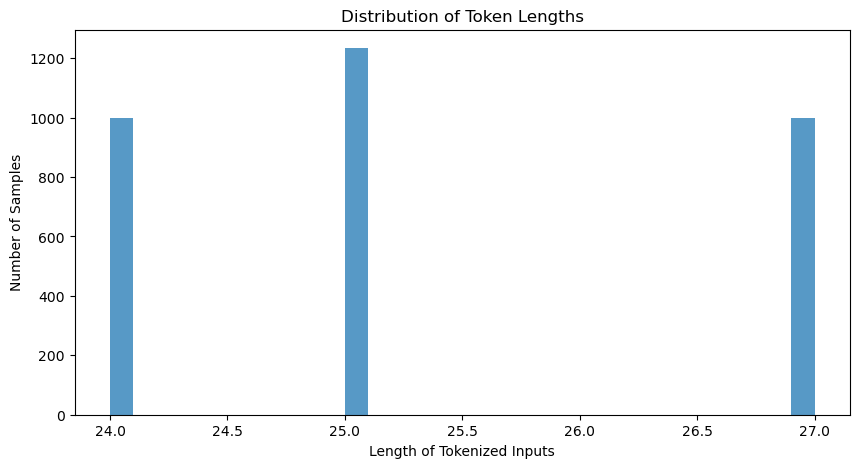

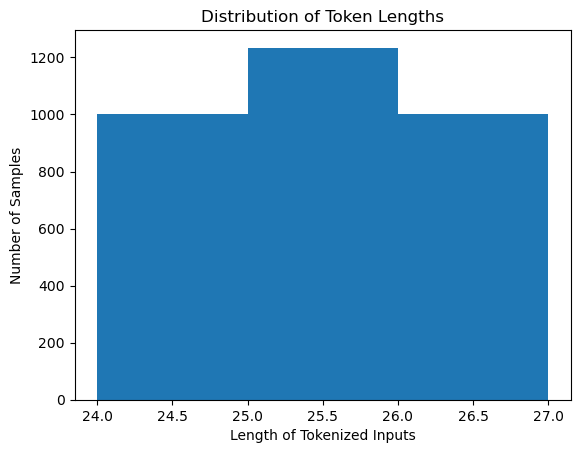

In [199]:
import matplotlib.pyplot as plt

# Calculate lengths of input_ids
lengths = [len(x['input_ids']) for x in tokenized_datasets['train']]

# Plot the distribution of lengths
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=30, alpha=0.75)
plt.title('Distribution of Token Lengths')
plt.xlabel('Length of Tokenized Inputs')
plt.ylabel('Number of Samples')
plt.show()


lengths = [len(input_ids) for input_ids in tokenized_datasets['train']['input_ids']]
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1, 1))
plt.title('Distribution of Token Lengths')
plt.xlabel('Length of Tokenized Inputs')
plt.ylabel('Number of Samples')
plt.show()


In [200]:
# Now let's train!
trainer.train() # 

Step,Training Loss,Validation Loss,Precision,Recall,F1
50,No log,0.616486,0.535354,0.417323,0.469027
100,No log,0.588079,0.548780,0.708661,0.618557
150,No log,0.581301,0.570552,0.732283,0.641379
200,No log,0.553986,0.563218,0.771654,0.651163
250,No log,0.691815,0.591195,0.740157,0.657343
300,No log,0.606466,0.578616,0.724409,0.643357
350,No log,0.632936,0.625000,0.787402,0.696864
400,No log,0.634331,0.669903,0.543307,0.600000
450,No log,0.958461,0.562130,0.748031,0.641892
500,0.364400,1.042668,0.678261,0.614173,0.644628


TrainOutput(global_step=1015, training_loss=0.22122414352858594, metrics={'train_runtime': 52.5385, 'train_samples_per_second': 307.774, 'train_steps_per_second': 19.319, 'total_flos': 224305258027080.0, 'train_loss': 0.22122414352858594, 'epoch': 5.0})

In [201]:
# Once we finish training, we can evaluate the model on the dev set. Note that
# since we specified the trainer to load the best model at the end, the 
# trainer will automatically load the best model for us to use here.
evaluation_results = trainer.evaluate()
print(evaluation_results)

{'eval_loss': 1.4326199293136597, 'eval_precision': 0.6241610738255033, 'eval_recall': 0.7322834645669292, 'eval_f1': 0.6739130434782609, 'eval_runtime': 0.2555, 'eval_samples_per_second': 1408.839, 'eval_steps_per_second': 90.009, 'epoch': 5.0}


In [202]:
# TODO: Use the trainer to predict() on the test set and then score the predictions
test_preds = trainer.predict(tokenized_datasets["test"])

In [203]:
test_preds

PredictionOutput(predictions=array([[-3.6910927 ,  3.2452316 ],
       [-3.2578387 ,  3.2011333 ],
       [ 4.4020247 , -3.9719384 ],
       [-4.210527  ,  4.0627294 ],
       [-2.9883008 ,  2.2381265 ],
       [-3.0179107 ,  2.970654  ],
       [-3.807501  ,  3.5123117 ],
       [ 4.1031933 , -4.0753193 ],
       [-3.619353  ,  3.3371494 ],
       [-3.1520643 ,  3.695163  ],
       [ 4.5850635 , -4.379095  ],
       [-3.751736  ,  3.8347638 ],
       [ 2.6644015 , -2.1591234 ],
       [-3.8350573 ,  3.2798858 ],
       [ 3.11847   , -3.2682972 ],
       [ 4.009467  , -4.271767  ],
       [ 4.636856  , -4.425795  ],
       [ 2.752719  , -2.501089  ],
       [ 2.78582   , -3.0988066 ],
       [-3.6904094 ,  2.9240434 ],
       [-3.984581  ,  3.9898307 ],
       [ 4.439133  , -4.261175  ],
       [ 4.3689027 , -4.1627774 ],
       [ 4.6228433 , -4.61661   ],
       [-4.2661724 ,  3.8649497 ],
       [-3.808729  ,  3.27996   ],
       [ 4.530772  , -4.417711  ],
       [ 4.119361  , -4.46